In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
csv_dir = os.path.join(output_dir, 'csv')
os.makedirs(png_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/fit_data.py

## Input

In [4]:
chain = 'Arbitrum'

In [5]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('AUM & Glp Supply'):
        fnames['AUM & Glp Supply'] = fname
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
fnames

{'Glp Price Comparison': 'Glp Price Comparison_2021-08-31_2022-08-02.csv',
 'AUM & Glp Supply': 'AUM & Glp Supply_2021-08-31_2022-08-02.csv'}

In [6]:
# create input-dependent dirs
save_fig_dir = os.path.join(png_dir, chain)
save_csv_dir = os.path.join(csv_dir, chain)
os.makedirs(save_fig_dir, exist_ok=True)
os.makedirs(save_csv_dir, exist_ok=True)

## Prep Data

In [7]:
# In the 'AUM & Glp Supply' file, col `aum` is in $, and `glpSupply` in quantity/count; 
# each row is the total stock measured at the end of the day. 
#
# I checked that `aum` == `glpSupply` * `glpPrice`, where `glpPrice` is from the 'Glp Price Comparison' file.
# So this `aum` is only a GLP `aum`, and it doesn't include staked GMX. So it doesn't capture the full picture. 
# Let's ignore it.
# 
# To calculate the net GLP supply (mint amount - burn amount) for each day, 
# - take the difference of total stock of glpSupply between two consecutive dates. 
# To calculate the net dollar flow for each day, simply do
# - net supply * (daily avg) glp price, which can be taken from the price file.

daily_stock = pd.read_csv(os.path.join(data_dir, chain, fnames['AUM & Glp Supply']), 
                          parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpSupply'])
# drop the last row because the most recent date may not be a full day
daily_stock = daily_stock.iloc[:-1, :]
daily_stock.head()

,glpSupply
Date,
2021-08-31,"8,229.0548"
2021-09-01,"973,717.9555"
2021-09-02,"1,620,503.2873"
2021-09-03,"1,624,108.2897"
2021-09-04,"1,668,759.9557"


In [8]:
# calculate daily flow by taking the difference between today's stock and yesterday's 
daily_flow = daily_stock - daily_stock.shift(1)
daily_flow.head()

,glpSupply
Date,
2021-08-31,NaN
2021-09-01,"965,488.9007"
2021-09-02,"646,785.3318"
2021-09-03,"3,605.0024"
2021-09-04,"44,651.6660"


In [9]:
daily_prices = pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                           parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpPrice'])
daily_prices.head()

,glpPrice
Date,
2021-08-31,1.1935
2021-09-01,1.2933
2021-09-02,1.2883
2021-09-03,1.3062
2021-09-04,1.3077


In [10]:
# calculate net dollar flow for GLP
daily_flow = (pd.merge(daily_flow, daily_prices.loc[:, 'glpPrice'], left_index=True, right_index=True)
                .assign(net_dollar_flow = lambda x: x.glpSupply * x.glpPrice)
                .drop(['glpSupply', 'glpPrice'], axis=1)
                .dropna() # drop missing rows
             )
daily_flow.head()

,net_dollar_flow
Date,
2021-09-01,"1,248,702.1227"
2021-09-02,"833,226.5943"
2021-09-03,"4,708.9158"
2021-09-04,"58,389.3636"
2021-09-05,"34,078.1657"


In [11]:
# save daily net dollar flow data for future analyses
daily_flow.reset_index().to_csv(os.path.join(save_csv_dir, 'daily_ndf.csv'), index=False)

## GLP Net Dollar Flow 

### Monthly

In [12]:
monthly_ndf = daily_flow.groupby(daily_flow.index.to_period('M')).net_dollar_flow.sum()
monthly_ndf

Date
2021-09    30,663,878.5985
2021-10    31,574,746.0496
2021-11    44,559,864.6556
2021-12    -1,869,741.9759
2022-01    46,726,654.5248
2022-02    32,057,175.7400
2022-03    45,519,802.0586
2022-04    32,462,537.3397
2022-05     9,935,268.8713
2022-06   -33,006,399.0889
2022-07     9,120,711.5027
2022-08     5,930,780.9705
Freq: M, Name: net_dollar_flow, dtype: float64

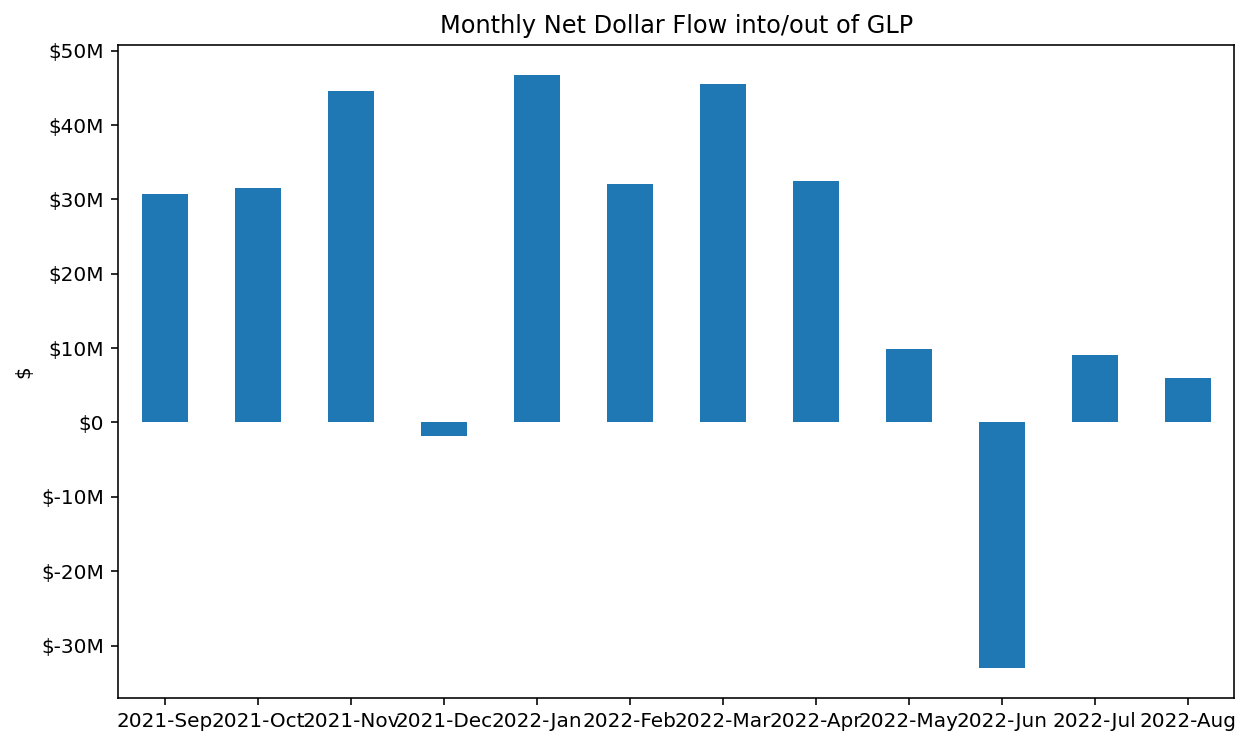

In [13]:
ax = monthly_ndf.plot(kind='bar', title="Monthly Net Dollar Flow into/out of GLP",
                      ylabel='$', xlabel='', rot=0)
ax.set_xticklabels(monthly_ndf.index.to_timestamp().strftime('%Y-%b'))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.savefig(os.path.join(save_fig_dir, 'monthly_ndf.png'), dpi=300);

- The NDF is above `$30M` for 7 out of 10 months.
- In May 2022, Terra UST blew up, and there was a net inflow of `~$10M` to GLP on Arbitrum.
- In June 2022, `~$33M` (net) left GLP as we entered the crypto bear market.

### Weekly

In [14]:
weekly_ndf = daily_flow.groupby(daily_flow.index.to_period('W')).net_dollar_flow.sum()
weekly_ndf.index.name = 'Week'
weekly_ndf.head()

Week
2021-08-30/2021-09-05   2,179,105.1621
2021-09-06/2021-09-12   9,562,918.0862
2021-09-13/2021-09-19   8,068,198.5426
2021-09-20/2021-09-26   8,943,695.4552
2021-09-27/2021-10-03   2,845,555.2625
Freq: W-SUN, Name: net_dollar_flow, dtype: float64

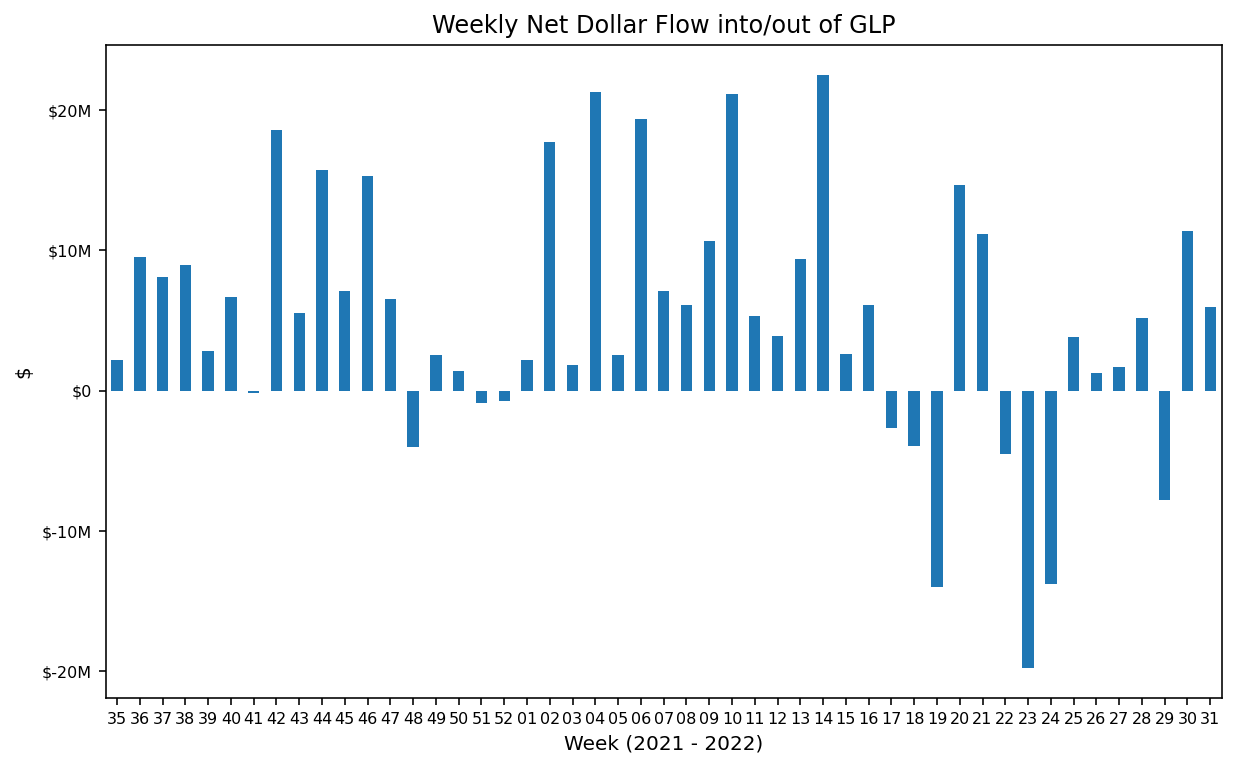

In [15]:
ax = weekly_ndf.plot(kind='bar', title="Weekly Net Dollar Flow into/out of GLP",
                     ylabel='$', xlabel='Week (2021 - 2022)', rot=0, fontsize=8)
ax.set_xticklabels(weekly_ndf.index.to_timestamp().strftime('%W'))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.savefig(os.path.join(save_fig_dir, 'weekly_ndf.png'), dpi=300);

### Rolling Averages

In [16]:
daily_flow['rolling_avg_7d'] = daily_flow.net_dollar_flow.rolling(7).mean()
daily_flow['rolling_avg_14d'] = daily_flow.net_dollar_flow.rolling(14).mean()
daily_flow['rolling_avg_30d'] = daily_flow.net_dollar_flow.rolling(30).mean()
daily_flow.head()

,net_dollar_flow,rolling_avg_7d,rolling_avg_14d,rolling_avg_30d
Date,,,,
2021-09-01,"1,248,702.1227",NaN,NaN,NaN
2021-09-02,"833,226.5943",NaN,NaN,NaN
2021-09-03,"4,708.9158",NaN,NaN,NaN
2021-09-04,"58,389.3636",NaN,NaN,NaN
2021-09-05,"34,078.1657",NaN,NaN,NaN


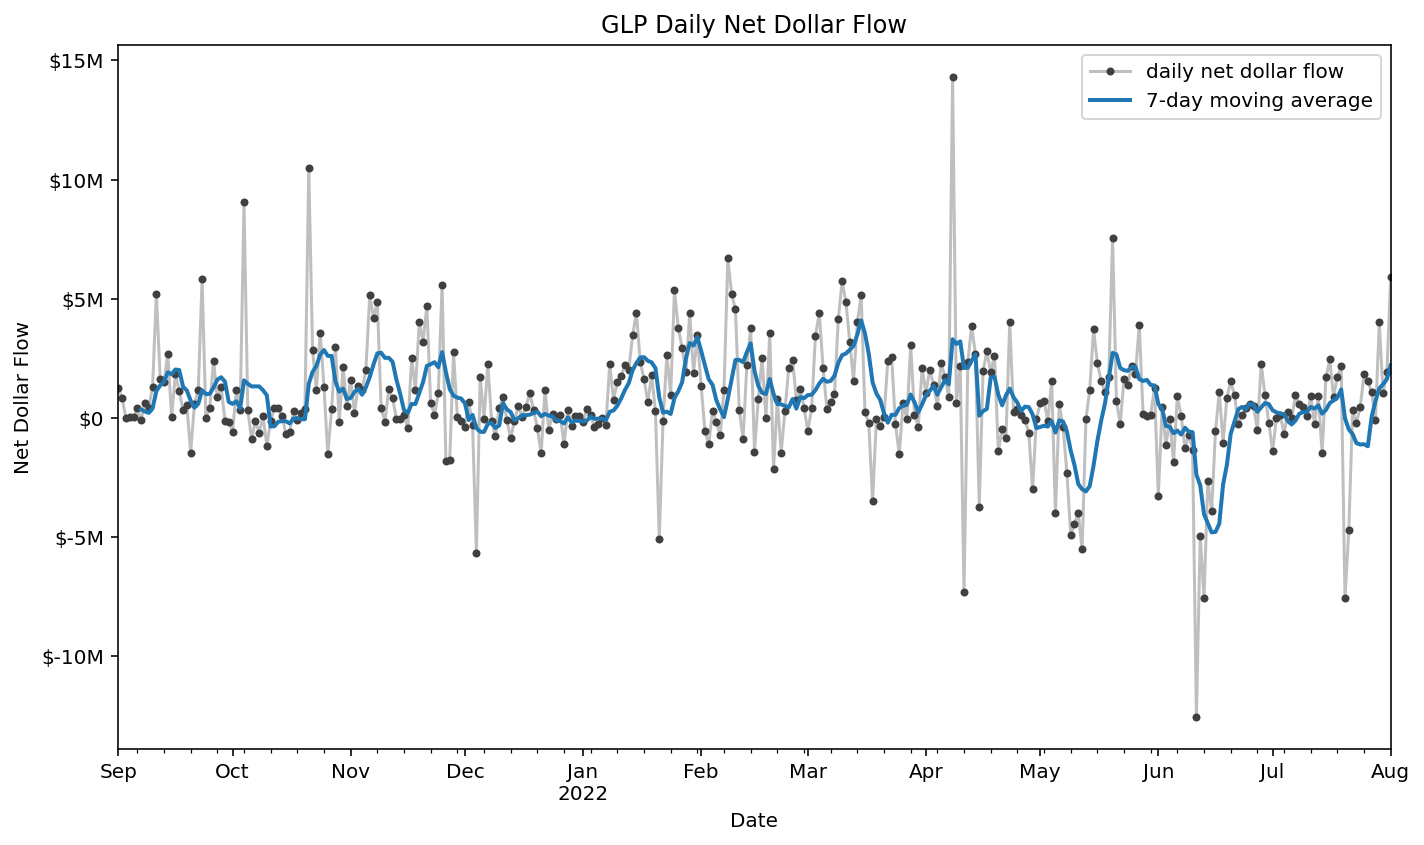

In [17]:
ax = plot_timeseries_with_trendline(
    daily_flow.net_dollar_flow, yhat=daily_flow.rolling_avg_7d, 
    title='GLP Daily Net Dollar Flow', ylabel='Net Dollar Flow', 
    ytru_legend='daily net dollar flow', 
    yhat_legend='7-day moving average')
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'ndf_7d_mavg.png'), dpi=300);

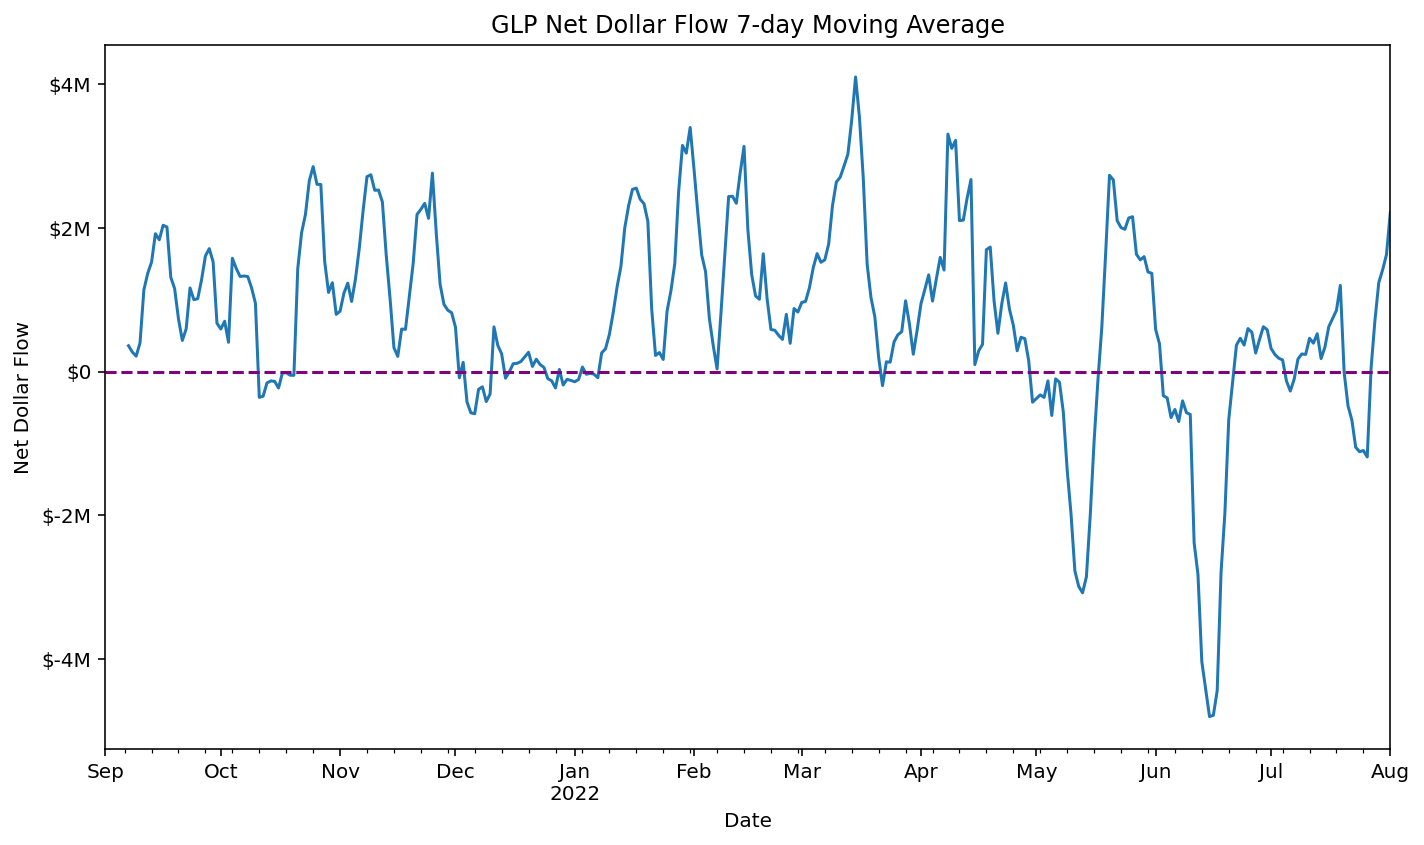

In [18]:
ax = daily_flow.rolling_avg_7d.plot(
    title='GLP Net Dollar Flow 7-day Moving Average', ylabel='Net Dollar Flow')
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
ax.axhline(0.5, linestyle='--', color='purple')
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'ndf_7d_mavg_magnified.png'), dpi=300);

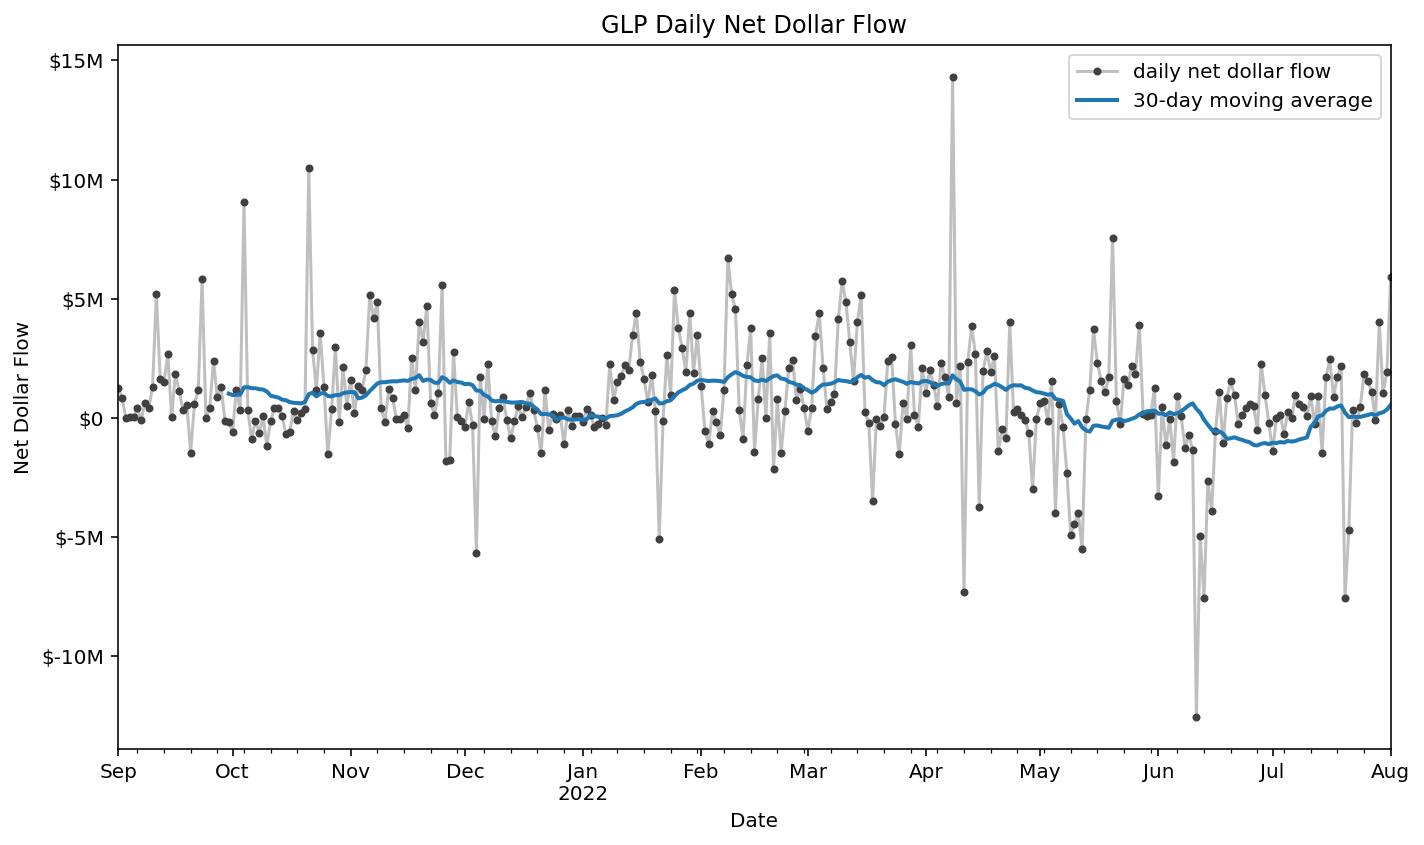

In [19]:
ax = plot_timeseries_with_trendline(
    daily_flow.net_dollar_flow, yhat=daily_flow.rolling_avg_30d, 
    title='GLP Daily Net Dollar Flow', ylabel='Net Dollar Flow', 
    ytru_legend='daily net dollar flow', 
    yhat_legend='30-day moving average')
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'ndf_30d_mavg.png'), dpi=300);

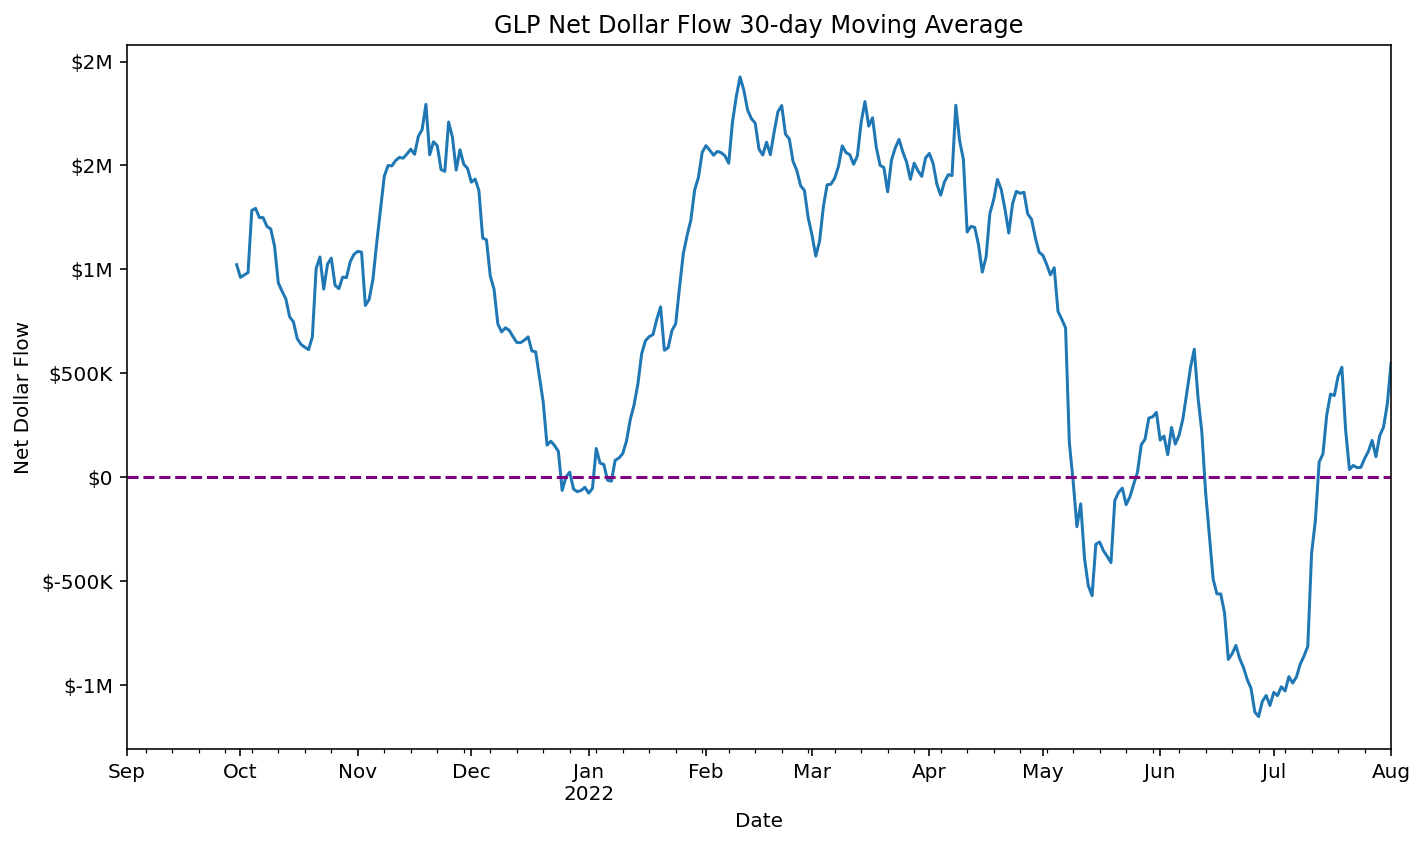

In [20]:
ax = daily_flow.rolling_avg_30d.plot(
    title='GLP Net Dollar Flow 30-day Moving Average', ylabel='Net Dollar Flow')
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
ax.axhline(0.5, linestyle='--', color='purple')
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'ndf_30d_mavg_magnified.png'), dpi=300);